# Pancreatic cancer is ranked among the most deadliest cancers due to its low 5-year-survival rate and difficulty in successful diagnosis in its early stages in lack of direct characteristic biomarkers. However, methods based on machine learning provide potential means to identify pancreatic cancer using urinary biomarkers. The objective of this  project aims to compare multiple classifier models and determine an optimal model to predict whether patients with unseen urinary biomarkers have pancreatic cancer. Being able to correctly detect pancreatic cancer in early stage promises a new approach in clinical diagnosis, which will certainly assist doctors to produce more accurate results.
# data could be found:  https://www.kaggle.com/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import math


# initial EDA 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/sample_data/Debernardi et al 2020 data.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [5]:
df=df.drop(columns=['sample_id','patient_cohort','sample_origin','stage','benign_sample_diagnosis'])
df.head()

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,81,F,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,51,M,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,61,M,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,62,M,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [6]:
print(df.shape)
print(df.info())

(590, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   sex            590 non-null    object 
 2   diagnosis      590 non-null    int64  
 3   plasma_CA19_9  350 non-null    float64
 4   creatinine     590 non-null    float64
 5   LYVE1          590 non-null    float64
 6   REG1B          590 non-null    float64
 7   TFF1           590 non-null    float64
 8   REG1A          306 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 41.6+ KB
None


In [7]:
# convert categorical variable to binary values
df['is_male']=pd.get_dummies(df["sex"],drop_first=True)
df.drop(columns=['sex'], inplace=True)
df.head()

,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,is_male
0,33,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000,0
1,81,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407,0
2,51,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN,1
3,61,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN,1
4,62,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN,1


In [8]:
df.isna().sum()

age                0
diagnosis          0
plasma_CA19_9    240
creatinine         0
LYVE1              0
REG1B              0
TFF1               0
REG1A            284
is_male            0
dtype: int64

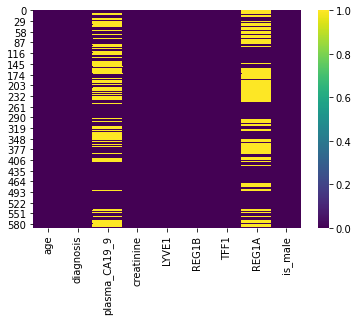

In [9]:
# check missinng values
sns.heatmap(df.isna() ,cmap='viridis')

##replacing miss values with mean of records with similar features


---



In [10]:
for i in range(len(df)):
  if math.isnan(df.at[i,'REG1A'])or df.at[i,'REG1A']==0:
    age=df.at[i,'age']
    is_male=df.at[i,'is_male']
    diagnosis=df.at[i,'diagnosis']

    subset=df.loc[(df['REG1A'].isnull()==False) & (df['age']==age)&(df['diagnosis']==diagnosis)&(df['is_male']==is_male)]
    df.at[i,'REG1A']=subset['REG1A'].mean()

  if math.isnan(df.at[i,'plasma_CA19_9']):
    age=df.at[i,'age']
    is_male=df.at[i,'is_male']
    diagnosis=df.at[i,'diagnosis']

    subset=df.loc[(df['plasma_CA19_9'].isnull()==False) & (df['age']==age)&(df['diagnosis']==diagnosis)&(df['is_male']==is_male)]
    df.at[i,'plasma_CA19_9']=subset['plasma_CA19_9'].mean()

df.head()



,age,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A,is_male
0,33,1,11.70000,1.83222,0.893219,52.94884,654.282174,1262.0000,0
1,81,1,25.38502,0.97266,2.037585,94.46703,209.488250,228.4070,0
2,51,1,7.00000,0.78039,0.145589,102.36600,461.141000,14.6725,1
3,61,1,8.00000,0.70122,0.002805,60.57900,142.950000,218.1755,1
4,62,1,9.00000,0.21489,0.000860,65.54000,41.088000,422.5405,1


In [11]:
df.dropna(inplace=True)

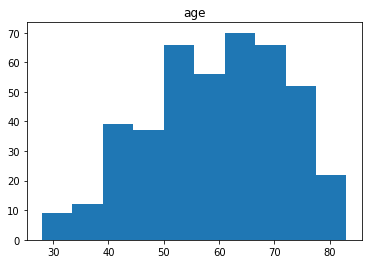

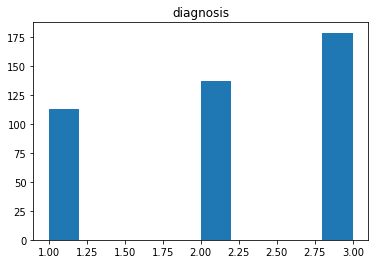

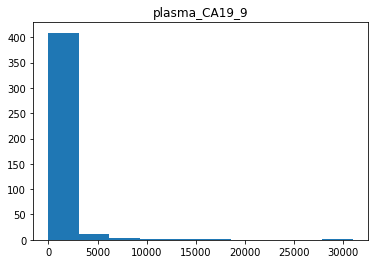

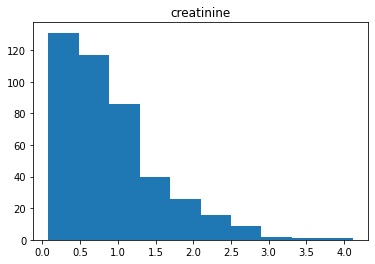

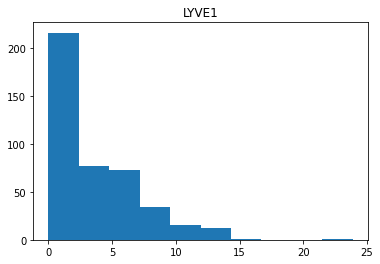

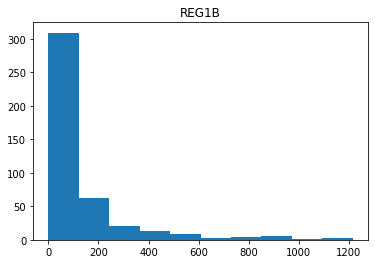

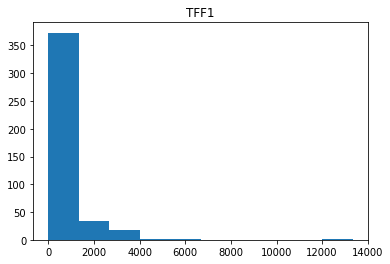

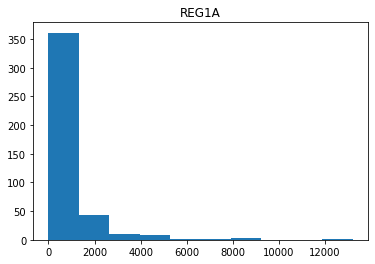

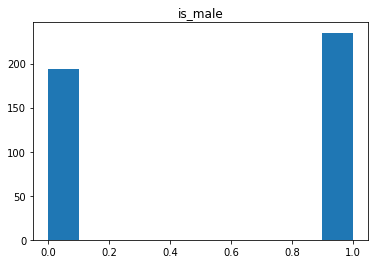

In [12]:
for col in df.columns:
  plt.hist(df[col])
  plt.title(col)
  plt.show()

In [13]:
y=df['diagnosis']
X=df.drop(columns='diagnosis',axis=1)
#Scaler=MinMaxScaler()
#X=Scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 1. Logistic Regression 

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  confusion_matrix,classification_report
from sklearn.model_selection import  cross_val_score
lr=LogisticRegression(max_iter=10000)
lr.fit(X_train,y_train)
predictions=lr.predict(X_test)
 

Confusion matrix, without normalization
[[21  7  1]
 [ 3 16  6]
 [ 0  1 31]]
Normalized confusion matrix
[[0.72413793 0.24137931 0.03448276]
 [0.12       0.64       0.24      ]
 [0.         0.03125    0.96875   ]]


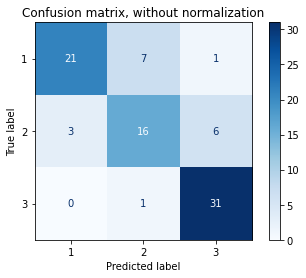

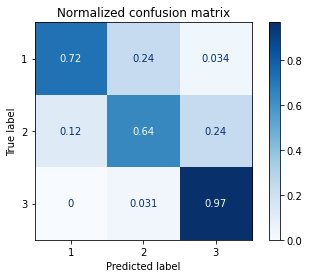

In [15]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [16]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

           1       0.72      0.88      0.79        24
           2       0.64      0.67      0.65        24
           3       0.97      0.82      0.89        38

    accuracy                           0.79        86
   macro avg       0.78      0.79      0.78        86
weighted avg       0.81      0.79      0.79        86



In [17]:
# improve results with cross validation
lr_cv_scores=cross_val_score(lr,X,y,cv=5)
print('Accuracy scores for the 5 folds multinominal LR: ',lr_cv_scores)
print('mean of Accuracy scores for the 5 folds multinominal LR= {:.3f}'.format(np.mean(lr_cv_scores)))

Accuracy scores for the 5 folds multinominal LR:  [0.65116279 0.75581395 0.76744186 0.6744186  0.77647059]
mean of Accuracy scores for the 5 folds multinominal LR= 0.725


# 2. Random Forest

In [18]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier()

param_grid = {
    'n_estimators': [100,200,400,700],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_estimator_
CV_rfc.best_params_

{'max_features': 'sqrt', 'n_estimators': 100}

In [19]:
rfc=RandomForestClassifier(n_estimators=700,max_features='log2')
rfc.fit(X_train,y_train)
prediction_rf=rfc.predict(X_test)

Confusion matrix, without normalization
[[17 12  0]
 [ 2 17  6]
 [ 0  1 31]]
Normalized confusion matrix
[[0.5862069 0.4137931 0.       ]
 [0.08      0.68      0.24     ]
 [0.        0.03125   0.96875  ]]


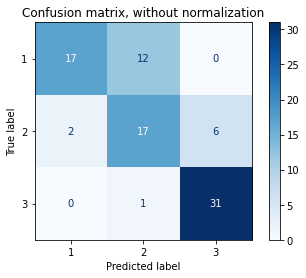

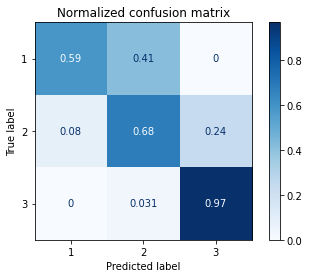

              precision    recall  f1-score   support

           1       0.59      0.89      0.71        19
           2       0.68      0.57      0.62        30
           3       0.97      0.84      0.90        37

    accuracy                           0.76        86
   macro avg       0.74      0.77      0.74        86
weighted avg       0.78      0.76      0.76        86



In [20]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
print(classification_report(prediction_rf,y_test))

In [21]:
# cross validation :
rfc_cv=RandomForestClassifier(n_estimators=700,max_features='log2')
rfc_cv_score=cross_val_score(rfc_cv,X,y,cv=5)
print('Accuracy scores for the 5 folds multinominal LR: ',rfc_cv_score)
print('mean of Accuracy scores for the 5 folds multinominal LR= {:.3f}'.format(np.mean(rfc_cv_score)))

Accuracy scores for the 5 folds multinominal LR:  [0.6744186  0.84883721 0.72093023 0.76744186 0.77647059]
mean of Accuracy scores for the 5 folds multinominal LR= 0.758


# 3.SVC

In [25]:
from sklearn.svm import  SVC
svc=SVC( kernel='linear')
svc.fit(X_train,y_train)
prediction_svc=svc.predict(X_test)
print(classification_report(y_test,prediction_svc))

              precision    recall  f1-score   support

           1       0.91      0.72      0.81        29
           2       0.68      0.68      0.68        25
           3       0.82      0.97      0.89        32

    accuracy                           0.80        86
   macro avg       0.80      0.79      0.79        86
weighted avg       0.81      0.80      0.80        86



Confusion matrix, without normalization
[[21  7  1]
 [ 2 17  6]
 [ 0  1 31]]
Normalized confusion matrix
[[0.72413793 0.24137931 0.03448276]
 [0.08       0.68       0.24      ]
 [0.         0.03125    0.96875   ]]


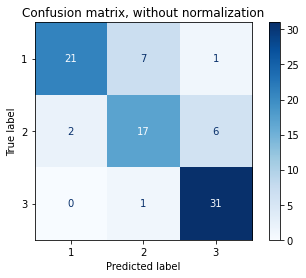

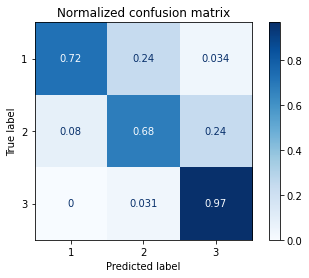

In [26]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [27]:
# svc with cross validation 

svc=SVC(kernel='linear')
svc_cv=cross_val_score(svc,X_train,y_train,cv=5)
print('Accuracy scores for the 5 folds SVM:',svc_cv)
print('Mean cross validation score SVM:{}'.format(np.mean(svc_cv)))

Accuracy scores for the 5 folds SVM: [0.71014493 0.63768116 0.8115942  0.63235294 0.72058824]
Mean cross validation score SVM:0.7024722932651322


# 3. KNN

In [33]:
from sklearn.neighbors import  KNeighborsClassifier
knn=KNeighborsClassifier()
param_knn={'n_neighbors':[5,6,7,8,10,12],
           'weights':['uniform', 'distance']}
knn_cv=GridSearchCV(estimator=knn,param_grid=param_knn,cv=5)
knn_cv.fit(X_train,y_train)
knn_cv.best_params_


{'n_neighbors': 6, 'weights': 'uniform'}

In [34]:
knn=KNeighborsClassifier(n_neighbors=6,weights='uniform')
knn.fit(X_train,y_train)
knn_prediction=knn.predict(X_test)
print(classification_report(y_test,knn_prediction))

              precision    recall  f1-score   support

           1       0.77      0.79      0.78        29
           2       0.63      0.48      0.55        25
           3       0.76      0.88      0.81        32

    accuracy                           0.73        86
   macro avg       0.72      0.72      0.71        86
weighted avg       0.72      0.73      0.72        86



Confusion matrix, without normalization
[[23  4  2]
 [ 6 12  7]
 [ 1  3 28]]
Normalized confusion matrix
[[0.79310345 0.13793103 0.06896552]
 [0.24       0.48       0.28      ]
 [0.03125    0.09375    0.875     ]]


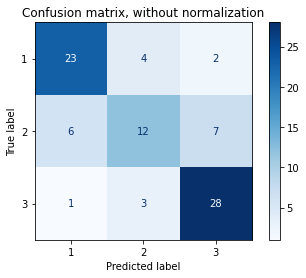

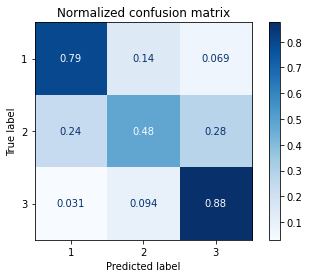

In [35]:
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(knn, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()